In [554]:
import torch
import numpy
import matplotlib.pyplot as plt
from definitions import model_save_dir
import os
from decision_transformer import DecisionTransformer
from utils import evaluate_on_env_array, evaluate_on_env_append
from environments.mazes import AltTmaze, CuedTmaze

from definitions import model_save_dir, ROOT_FOLDER


In [565]:
evaluate_on_env = evaluate_on_env_array

model_fn = 'CuedTmazeTransformer_7_31_15_4head.pt'

target = 1.

env = CuedTmaze(render_mode='human')


# model hyperparameters
n_blocks = 1
embed_dim = 32
context_len = 10
n_heads = 4
dropout_p = 0.1
state_dim = env.n_states
act_dim = 4


# load model
model = DecisionTransformer(
    state_dim=state_dim,
    act_dim=act_dim,
    n_blocks=n_blocks,
    h_dim=embed_dim,
    context_len=context_len,
    n_heads=n_heads,
    drop_p=dropout_p,
    action_mask_value=env.n_actions,
    state_mask_value=env.n_states
)


model.load_state_dict(torch.load(os.path.join(model_save_dir, model_fn)))
model.eval()


DecisionTransformer(
  (transformer): StackedBlocks(
    (blocks): ModuleList(
      (0): Block(
        (attention): CausalMultiheadAttention(
          (q_net): Linear(in_features=32, out_features=32, bias=True)
          (k_net): Linear(in_features=32, out_features=32, bias=True)
          (v_net): Linear(in_features=32, out_features=32, bias=True)
          (proj_net): Linear(in_features=32, out_features=32, bias=True)
          (att_dropout): Dropout(p=0.1, inplace=False)
          (proj_dropout): Dropout(p=0.1, inplace=False)
        )
        (mlp1): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
        )
        (mlp2): Sequential(
          (0): Linear(in_features=128, out_features=32, bias=True)
          (1): Dropout(p=0.1, inplace=False)
        )
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (

In [566]:
# zeros place holders
max_ep_len = 50

timesteps = torch.arange(start=0, end=max_ep_len, step=1).unsqueeze(0)
actions = torch.zeros((1, max_ep_len), dtype=torch.int32)
states = torch.zeros((1, max_ep_len), dtype=torch.int32)
rewards_to_go = torch.zeros((1, max_ep_len, 1), dtype=torch.float32)

# add same mask as used for training
states[:] = env.n_states
actions[:] = env.n_actions
rewards_to_go[:] = target

# init episode
running_state = 48  # 48 is the start state, optimal action is 1
env.reset(running_state)

t = 0
states[0, t] = running_state

padding_len = 0

input_timesteps = timesteps[:, :t+padding_len+1]
input_states = states[:, :t+padding_len+1]
input_actions = actions[:, :t+padding_len+1]
input_rewards_to_go = rewards_to_go[:, :t+padding_len+1]

_, act_preds, _, all_weights, mlp_activations = model.forward(input_timesteps,
                                                              input_states,
                                                              input_actions,
                                                              input_rewards_to_go)


In [567]:
input_states, input_actions, input_timesteps, input_rewards_to_go

(tensor([[48]], dtype=torch.int32),
 tensor([[4]], dtype=torch.int32),
 tensor([[0]]),
 tensor([[[1.]]]))

# step 1

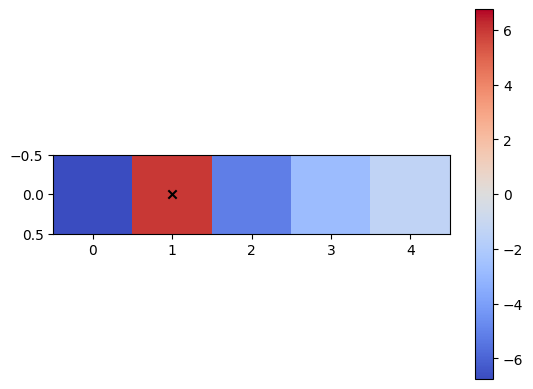

In [568]:
logits = act_preds.detach().numpy().squeeze(axis=0)

plt.imshow(logits, cmap='coolwarm', vmin=min(logits.min(), -logits.max()), vmax=max(logits.max(), -logits.min()))
plt.colorbar()
plt.scatter(logits.argmax(axis=1), range(logits.shape[0]), c='k', marker='x')

a = logits[t].argmax()


In [569]:
actions[0, t] = a
new_state, reward, done, _ = env.step(a)
t += 1
states[0, t] = new_state

In [570]:

input_timesteps = timesteps[:, :t+padding_len+1]
input_states = states[:, :t+padding_len+1]
input_actions = actions[:, :t+padding_len+1]
input_rewards_to_go = rewards_to_go[:, :t+padding_len+1]

_, act_preds, _, all_weights, mlp_activations = model.forward(input_timesteps,
                                                              input_states,
                                                              input_actions,
                                                              input_rewards_to_go)

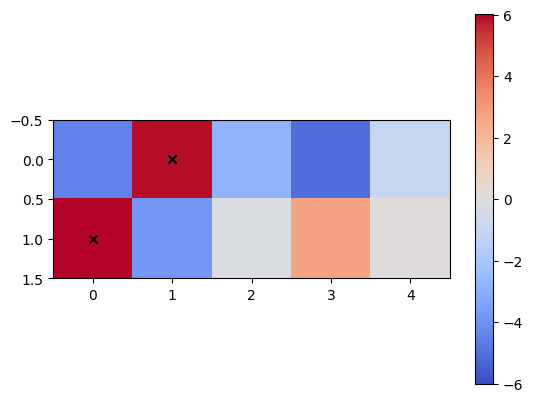

In [571]:
logits = act_preds.detach().numpy().squeeze(axis=0)

plt.imshow(logits, cmap='coolwarm', vmin=min(logits.min(), -logits.max()), vmax=max(logits.max(), -logits.min()))
plt.colorbar()
plt.scatter(logits.argmax(axis=1), range(logits.shape[0]), c='k', marker='x')

a = logits[t].argmax()

In [572]:
actions[0, t] = a
new_state, reward, done, _ = env.step(a)
t += 1
states[0, t] = new_state


In [573]:
input_timesteps = timesteps[:, :t+padding_len+1]
input_states = states[:, :t+padding_len+1]
input_actions = actions[:, :t+padding_len+1]
input_rewards_to_go = rewards_to_go[:, :t+padding_len+1]

_, act_preds, _, all_weights, mlp_activations = model.forward(input_timesteps,
                                                              input_states,
                                                              input_actions,
                                                              input_rewards_to_go)


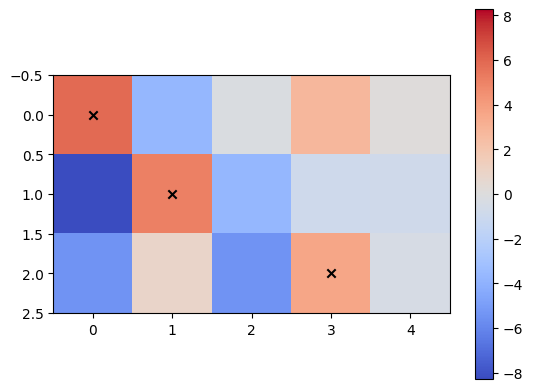

In [574]:
logits = act_preds.detach().numpy().squeeze(axis=0)

plt.imshow(logits, cmap='coolwarm', vmin=min(logits.min(), -logits.max()), vmax=max(logits.max(), -logits.min()))
plt.colorbar()
plt.scatter(logits.argmax(axis=1), range(logits.shape[0]), c='k', marker='x')

a = logits[t].argmax()
